#Course 02
Convolutional Neural Networks in TensorFlow

##Week03 Transfer Learning

### Model with the Transfer Learning : With and Without DropOut

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

https://www.tensorflow.org/tutorials/images/transfer_learning

In [0]:
pip install tensorflow --upgrade --force-reinstall

In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
# load the weights first for the model:
import os 

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-04-02 15:25:18--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.128, 2404:6800:4008:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   159MB/s    in 0.5s    

2020-04-02 15:25:19 (159 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
                                 input_shape = (150,150,3),
                                 include_top = False,
                                 weights = None )

pre_trained_model.load_weights(local_weights_file)

# Lets freeze the layers from re-training :

for layers in pre_trained_model.layers:
  layers.trainable = False

pre_trained_model.summary()


**Now i decide to take the output from the layer names : mixed7 which you will find in the summary and then I will use that to fir to my neural network**

In [0]:
last_layer = pre_trained_model.get_layer('mixed7')
print('Last Layer output shape : ',last_layer.output_shape)
last_output = last_layer.output

Last Layer output shape :  (None, 7, 7, 768)


In [0]:
# Lets now feed the output from this layer :

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(units = 1024 , activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units = 1 , activation = 'sigmoid')(x)

model = tf.keras.models.Model(pre_trained_model.input , x)


In [0]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 0.0001),
              metrics = ['accuracy'],
              loss = 'binary_crossentropy')

In [0]:
# Now lets download the cat-vs-dog dataset to proceed further :
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2020-04-02 10:34:33--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   193MB/s    in 0.3s    

2020-04-02 10:34:33 (193 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
# Unzip the file cotents :

import os 
import zipfile

zipped_folder_path = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(zipped_folder_path,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
# Unzipped file already has the train test and then cats dogs split :

# lets now create the directories to be used later ;

base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')

validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

In [0]:
# Now lets create the data pipelines :

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                  rescale = 1./255,
                  rotation_range = 40,
                  width_shift_range = 0.2,
                  height_shift_range = 0.2,
                  shear_range = 0.2,
                  zoom_range = 0.2,
                  horizontal_flip = True,
                  fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_directory(
                                    directory = train_dir,
                                    target_size = (150,150),
                                    batch_size = 20,
                                    class_mode = 'binary',
)

validation_datagen = ImageDataGenerator(
                   rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
                                   directory = validation_dir,
                                   target_size = (150,150),
                                   batch_size = 20,
                                   class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# Now lets fit the model :

history = model.fit_generator(
                    train_generator,
                    steps_per_epoch = 100,
                    validation_data = validation_generator,
                    validation_steps = 50,
                    verbose = 1,
                    epochs = 20
)

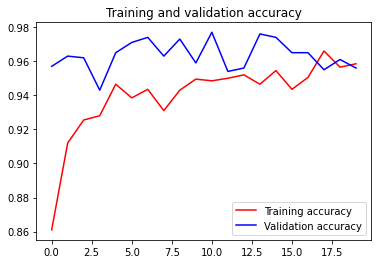

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

So clearly the model is overfitting the training data !!! So now we have already been using the data augmentation ..what else can we do ? 

Actually because of the complexity of the model the augmentation is also not able to control the overfitting . So what we can do is we can actually reduce the complexity by intrducing the concept of **DROPOUT**

Lets add the dropout layer and compile and retrain to see the changes !!!

In [0]:
# Lets now feed the output from this layer :


x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(units = 1024 , activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units = 1 , activation = 'sigmoid')(x)


model = tf.keras.models.Model(pre_trained_model.input , x)



In [0]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 0.0001),
              metrics = ['accuracy'],
              loss = 'binary_crossentropy')

In [0]:
# Now lets fit the model :

history = model.fit_generator(
                    train_generator,
                    steps_per_epoch = 100,
                    validation_data = validation_generator,
                    validation_steps = 50,
                    verbose = 1,
                    epochs = 20
)

In [0]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

Dropout does help because "Neighbour Neurons can have similar weights and thus can skew the final training "

###Exercise 3 - Horses vs. humans using Transfer Learning


This week your exercise will be to apply what you've learned about Transfer Learning to see if you can increase training accuracy for Horses v Humans. To avoid crazy overfitting, your validation set accuracy should be around 95% if you do it right!

Your training should automatically stop once it reaches this desired accuracy.

Let's now use Transfer Learning to increase the training accuracy for Horses v Humans!

NOTE: Please do not alter any of the provided code in the exercise. Only add your own code where indicated. Please do not add or remove any cells in the exercise. The grader will check specific cells based on the cell position. Please use the provided epoch values when training. Once you have completed your notebook assignment and received a final score, please save your notebook, run the final cell, and close your Jupyter Workspace. This will help optimize your Jupyter workspace performance for future assessments. Please note that this step will shut down your kernel, so it is important to save your work in advance of completing this step

In [0]:
# ATTENTION: Please do not alter any of the provided code in the exercise. Only add your own code where indicated
# ATTENTION: Please do not add or remove any cells in the exercise. The grader will check specific cells based on the cell position.
# ATTENTION: Please use the provided epoch values when training.

# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

In [0]:
#path_inception = f"{getcwd()}/../tmp2/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# load the weights first for the model:
import os 

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
path_inception = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
local_weights_file = path_inception

pre_trained_model = InceptionV3(
                                input_shape = (150,150,3),
                                include_top = False,
                                weights = None
                               )# Your Code Here

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  # Your Code Here
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

# Expected Output is extremely large, but should end with:

#batch_normalization_v1_281 (Bat (None, 3, 3, 192)    576         conv2d_281[0][0]                 
#__________________________________________________________________________________________________
#activation_273 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_273[0][0] 
#__________________________________________________________________________________________________
#mixed9_1 (Concatenate)          (None, 3, 3, 768)    0           activation_275[0][0]             
#                                                                 activation_276[0][0]             
#__________________________________________________________________________________________________
#concatenate_5 (Concatenate)     (None, 3, 3, 768)    0           activation_279[0][0]             
#                                                                 activation_280[0][0]             
#__________________________________________________________________________________________________
#activation_281 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_281[0][0] 
#__________________________________________________________________________________________________
#mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_273[0][0]             
#                                                                 mixed9_1[0][0]                   
#                                                                 concatenate_5[0][0]              
#                                                                 activation_281[0][0]             
#==================================================================================================
#Total params: 21,802,784
#Trainable params: 0
#Non-trainable params: 21,802,784

--2020-04-02 15:40:30--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  67.7MB/s    in 1.2s    

2020-04-02 15:40:31 (67.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                              

In [0]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output# Your Code Here

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

last layer output shape:  (None, 7, 7, 768)


In [0]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97):
      print("\nReached 97.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(units = 1024,activation = 'relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (units = 1 , activation = 'sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()

# Expected output will be large. Last few lines should be:

# mixed7 (Concatenate)            (None, 7, 7, 768)    0           activation_248[0][0]             
#                                                                  activation_251[0][0]             
#                                                                  activation_256[0][0]             
#                                                                  activation_257[0][0]             
# __________________________________________________________________________________________________
# flatten_4 (Flatten)             (None, 37632)        0           mixed7[0][0]                     
# __________________________________________________________________________________________________
# dense_8 (Dense)                 (None, 1024)         38536192    flatten_4[0][0]                  
# __________________________________________________________________________________________________
# dropout_4 (Dropout)             (None, 1024)         0           dense_8[0][0]                    
# __________________________________________________________________________________________________
# dense_9 (Dense)                 (None, 1)            1025        dropout_4[0][0]                  
# ==================================================================================================
# Total params: 47,512,481
# Trainable params: 38,537,217
# Non-trainable params: 8,975,264


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [0]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

--2020-04-02 16:11:58--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.128, 2404:6800:4008:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   272MB/s    in 0.5s    

2020-04-02 16:11:59 (272 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-04-02 16:12:02--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.128, 2404:6800:4008:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/z

In [0]:
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir,'horses')# Your Code Here
train_humans_dir = os.path.join(train_dir,'humans')# Your Code Here

validation_horses_dir = os.path.join(validation_dir,'horses')# Your Code Here
validation_humans_dir = os.path.join(validation_dir,'humans')# Your Code Here

train_horses_fnames = os.listdir(train_horses_dir)# Your Code Here
train_humans_fnames = os.listdir(train_humans_dir)# Your Code Here
validation_horses_fnames = os.listdir(validation_horses_dir)# Your Code Here
validation_humans_fnames = os.listdir(validation_humans_dir)# Your Code Here

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

# Expected Output:
# 500
# 527
# 128
# 128

500
527
128
128


In [0]:
# Add our data-augmentation parameters to ImageDataGenerator


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale = 1.0/255.,
                rotation_range = 40,
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                shear_range = 0.2,
                horizontal_flip = True,
                fill_mode ='nearest'
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                              directory =  train_dir,
                              target_size = (150,150),
                              batch_size = 13,
                              class_mode = 'binary'
)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( 
                               directory = validation_dir,
                               target_size = (150,150),
                               batch_size = 8,
                               class_mode = 'binary'   
)

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [0]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 97% accuracy


# callbacks = # Your Code Here
# history = model.fit_generator(# Your Code Here (set epochs = 3))


callbacks = myCallback()
history = model.fit_generator(
                              train_generator,
                              steps_per_epoch = 79,
                              validation_data = validation_generator,
                              validation_steps = 32,
                              epochs = 3,
                              verbose = 2,
                              callbacks = [callbacks]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 79 steps, validate for 32 steps
Epoch 1/3

Reached 97.0% accuracy so cancelling training!
79/79 - 12s - loss: 0.0558 - accuracy: 0.9825 - val_loss: 4.2100e-05 - val_accuracy: 1.0000


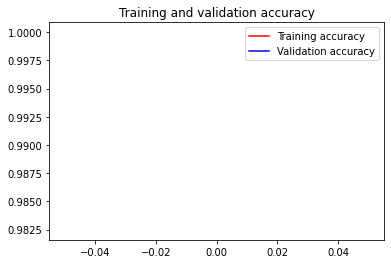

<Figure size 432x288 with 0 Axes>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

###### Submission Instructions

In [0]:
# Now click the 'Submit Assignment' button above.

##### When you're done or would like to take a break, please run the two cells below to save your work and close the Notebook. This will free up resources for your fellow learners. 

In [0]:
# %%javascript
# <!-- Save the notebook -->
# IPython.notebook.save_checkpoint();

In [0]:
# %%javascript
# IPython.notebook.session.delete();
# window.onbeforeunload = null
# setTimeout(function() { window.close(); }, 1000);